<a href="https://colab.research.google.com/github/diegobnh/ifba/blob/main/PerformanceCounters_ARM32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive 
drive.mount('/mntDrive', force_remount=True)

Mounted at /mntDrive


# Selecting Performance Monitoring Counter (pmc) on ARM Architecture


# Problem

---



One way to analyze the application's performance is to collect data from registers contained within the processor. Almost all CPU has a fixed number of registers which can be used to monitor application performance. These registers we will call Performance Monitoring Counter (PMC). The board analyzed in this experiment is called Odroid XU4. This board also has two CPU types: A7 (little core) and A15 (big core) with a maximum number of pmc per core of 4 and 6, respectively. Given a wide option of information that can be collected from the arm 32 architecture, only 4 for little and 6 for big can be collected at a time. The challenge is to know which information to collect that most contributes to explain the execution time.


# PMCs on Odroid

---

In little core only four pmc can be collected. In big core only six pmc can be collected. In total, 33 pmcs in little and 56 pmcs in big were analyzed as shown below:



*   Little core

inst_fetch_refill:0x01,inst_fetch_tlb_refill:0x02,data_rw_refill:0x03,data_rw_cache_access:0x04,data_rw_tlb_refill:0x05,data_read_exec:0x06,data_write_exec:0x07,ins_exec:0x08,excep_taken:0x09,excep_exec:0x0A,change_pc:0x0C,imed_branch_exec:0x0D,proc_return:0x0E,un_load_store:0x0F,br_pred:0x10,branches:0x12,data_mem_access:0x13,inst_cache_access:0x14,dcache_evic:0x15,l2d_cache_access:0x16,l2d_cache_refill:0x17,l2d_cache_write:0x18,bus_access:0x19,bus_cycle:0x1D,bus_access_read:0x60,bus_access_write:0x61,ext_mem_req:0xC0,no_cache_ext_mem_req:0xC1,enter_read_alloc_mode:0xC4,read_alloc_mode:0xC5,reserved:0xC6,data_w_stalls:0xC9,data_snooped:0xCA.
  

*   Big core

L1I_CACHE_REFILL:0x01,L1I_TLB_REFILL:0x02,L1D_CACHE_REFILL:0x03,L1D_CACHE_ACCESS:0x04,L1D_TLB_REFILL:0x05,INSTR_RETIRED:0x08,EXC_TAKEN:0x09,BR_MIS_PRED:0x10,BR_PRED:0x12,MEM_ACCESS:0x13,L1I_CACHE_ACCESS:0x14,L1D_CACHE_WB:0x15,L2D_CACHE_ACCESS:0x16,L2D_CACHE_REFILL:0x17,L2D_CACHE_WB:0x18,BUS_ACCESS:0x19,INST_SPEC:0x1B,BUS_CYCLES:0x1D,L1D_CACHE_LD:0x40,L1D_CACHE_ST:0x41,L1D_CACHE_REFILL_LD:0x42,L1D_CACHE_REFILL_ST:0x43,L1D_CACHE_WB_VICTIM:0x46,L1D_CACHE_WB_CLEAN:0x47,L1D_CACHE_INVAL:0x48,L1D_TLB_REFILL_LD:0X4C,L1D_TLB_REFILL_ST:0X4D,L2D_CACHE_LD:0x50,L2D_CACHE_ST:0x51,L2D_CACHE_REFILL_LD:0x52,L2D_CACHE_REFILL_ST:0x53,L2D_CACHE_WB_VICTIM:0x56,L2D_CACHE_INVAL:0x58,BUS_ACCESS_LD:0x60,BUS_ACCESS_ST:0x61,BUS_ACCESS_SHARED:0x62,BUS_ACCESS_NORMAL:0x64,MEM_ACCESS_LD:0x66,MEM_ACCESS_ST:0X67,UNALIGNED_LD_SPEC:0x68,UNALIGNED_ST_SPEC:0x69,UNALIGNED_LDST_SPEC:0x6A,LDREX_SPEC:0x6C,STREX_PASS_SPEC:0x6D,STREX_FAIL_SPEC:0x6E,LD_SPEC:0x70,ST_SPEC:0x70,LDST_SPEC:0x72,DP_SPEC:0x73,ASE_SPEC:0x74,VFP_SPEC:0x75,PC_WRITE_SPEC:0x76,BR_IMMED_SPEC:0x78,BR_RETURN_SPEC:0x79,BR_INDIRECT_SPEC:0x7A,DMB_SPEC:0x7E

# Applications

---



We chose bots for being a suite that makes use of the openmp. In addition, in bots you can see applications that have the best performance in the three configurations analyzed. Some suites is hard to find applications that perform better, for example, in the smallest configuration analyzed, in this case 4 little. These are the bot applications:


*   FFT: Computes a Fast Fourier Transformation.
*   Fib: Computes the nth fibonacci number using a recursive paralellization.
*   Floorplan: Computes the optimal placement of cells in a floorplan.
*   Health: Simulates a country health system.
*   NQueens: Finds solutions of the N Queens problem.
*   Sort: Uses a mixture of sorting algorithms to sort a vector.
*   SparseLU: Computes the LU factorization of a sparse matrix.
*   Strassen: Computes a matrix multiply with Strassen's method.



# Global variables, methods and library

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.model_selection import CVScores
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt


import statsmodels.api as sm
import operator
import timeit

import scipy.cluster.hierarchy as shc
from enum import Enum
from scipy.spatial.distance import pdist

from collections import defaultdict

FILTER_METHOD, FEATURE_IMPORTANCE_DTR, FEATURE_IMPORTANCE_RFR, RFE_LINEAR, RFI_LINEAR, RFI_DTR, RFI_RFR = range(7)
PERFORMANCE_TARGET, POWER_TARGET = range(2)    
FOUR_LITTLE, FOUR_BIG, FOUR_LITTLE_FOUR_BIG, FOUR_LITTLE_FOUR_BIG_L, FOUR_LITTLE_FOUR_BIG_B = range(5)

g_number_iterations = 30

#Will remove lines if exist outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#Will remove columns if exist low std by column
def remove_low_std(file_path,threshold):
    df = pd.read_csv(file_path)     
    columns_to_drop = list(df.loc[:, df.std() < threshold].columns)
    print("Num columns to remove:",columns_to_drop)
    if columns_to_drop.count('speedup4l') > 0 or columns_to_drop.count('speedup4b') > 0 or columns_to_drop.count('speedup4b4l') > 0 : 
      print("target column will be removed. !!!!")
    if columns_to_drop.count('power') > 0:    
      print("target column will be removed. !!!!")
    df = df.drop(columns_to_drop, axis=1)    
    return df

def remove_lines_zero_values(file_path):
    maximum_zero_per_line=10
    df = pd.read_csv(file_path) 
    new_df = df.drop(df[df.eq(0).sum(axis=1)>maximum_zero_per_line].index)
    return new_df

def print_performance(list_scores,list_pmcs):
    print("")
    for i in range(len(list_pmcs)):
       my_list =  list_pmcs[i]
       my_formatted_list = [ '%02d' % elem for elem in my_list ] 
       print("Mean Accuracy: {0:.2f} ".format(round(list_scores[i],2)),my_formatted_list)
    print("Final Mean : {0:.2f} ".format(round(sum(list_scores)/len(list_scores),2)))

def print_selected_pmcs(my_dict, num_pmcs):    
    dictionary = sorted(my_dict.items(), key=operator.itemgetter(1), reverse=True)
    for i in range(num_pmcs):
       string = "\'"+dictionary[i][0]+"\'" 
       print(string, end =",")   

def rmsle_error(y_true, y_pred): 
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def score_regression(y_true, y_pred, report=True):
    """
    Create regression score
    :param y:
    :param y_hat:
    :return:
    """
    r2 = r2_score(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    rmsle = rmsle_error(y_true, y_pred)

    report_string = "---Regression Score--- \n"
    report_string += "R2 = " + str(r2) + "\n"
    report_string += "RMSE = " + str(rmse) + "\n"
    report_string += "RMSLE (kaggle) = " + str(rmsle) + "\n"
    report_string += "MAE = " + str(mae) + "\n"

    #if report:
    #    print(report_string)
    print(report_string)
    #return mae, report_string 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Check the machine

If exist any gpu 

In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

''

The linux distribution

In [7]:
!uname -a
!cat /etc/lsb-release

Linux 4cb297fd88ea 5.4.188+ #1 SMP Sun Apr 24 10:03:06 PDT 2022 x86_64 x86_64 x86_64 GNU/Linux
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"


Number of cores

In [8]:
!getconf _NPROCESSORS_ONLN 

2


# Explore Data

---

After collecting all performance counters(33 in little and 56 in big), a dataset was created containing the average of each performance counter for each application. Besides that, all pmcs are normalized by cycles.

Three different types of configurations were analyzed: 4b4l (all cores enabled), 4b (four big cores enabled) and 4l (four little cores enabled). Although the configuration space is small they are quite representative.

We model our problem as Multi Target Regression. So, the last 3 columns represent the speedup of time in 4l, 4b and 4b4l configuration. Speedup is calculated by dividing the runtime in one configuration by another. Values greater than 1 indicate that the configuration has a shorter execution time. The higher the value, the shorter the runtime. Values less than 1 indicate a longer execution time.

<img src="http://drive.google.com/uc?export=view&id=1xihH1i1vpl_EgrTMFZhb5A7vdbGhBmGC">

In [4]:
import pandas as pd

path = "/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/performance/4l.csv"
df = pd.read_csv(path)

df.head(8)

,cycles:0x11,inst_fetch_refill:0x01,inst_fetch_tlb_refill:0x02,data_rw_refill:0x03,data_rw_cache_access:0x04,data_rw_tlb_refill:0x05,data_read_exec:0x06,data_write_exec:0x07,ins_exec:0x08,excep_taken:0x09,...,ext_mem_req:0xC0,no_cache_ext_mem_req:0xC1,enter_read_alloc_mode:0xC4,read_alloc_mode:0xC5,reserved:0xC6,data_w_stalls:0xC9,data_snooped:0xCA,speedup4l,speedup4b,speedup4b4l
0,1.724142e+08,1.101148e+06,86393.571429,8.694889e+06,1.548712e+09,1.531286e+06,1.217117e+08,3.625227e+07,6.488462e+08,2478.992857,...,12.771429,1.560454e+06,6.686603e+06,1.551183e+09,4.946533e+06,0,0,1,0.974523,0.494156
1,8.790461e+07,2.185820e+06,27433.285714,4.380286e+06,7.276851e+08,3.211301e+05,7.251012e+07,2.670878e+07,3.363738e+08,270558.487013,...,5.194805,3.558561e+05,3.725779e+06,7.710384e+08,4.546996e+06,0,0,1,1.003448,0.433184
2,9.256999e+07,8.620565e+05,2093.617470,2.890693e+06,8.404703e+08,1.809868e+04,1.764113e+08,1.558772e+08,4.770779e+08,75395.129518,...,128657.400602,5.611237e+08,1.442802e+08,8.386960e+08,4.332155e+05,0,0,1,2.077785,1.289714
3,1.749022e+08,4.628479e+05,11357.884058,7.113547e+06,1.561331e+09,1.149626e+05,8.541488e+07,3.850191e+07,4.263165e+08,5827.202899,...,8.753623,2.484829e+06,5.123229e+06,1.551890e+09,2.333904e+06,0,0,1,1.251237,0.789967
4,1.605985e+08,2.540257e+06,11414.084211,6.034897e+06,1.461004e+09,2.356289e+05,1.612279e+08,5.526779e+07,9.102503e+08,295846.010526,...,4.926316,3.910679e+05,7.918789e+06,1.480890e+09,5.912490e+06,0,0,1,0.932477,0.507174
5,6.418516e+07,1.658328e+05,2283.994220,2.499099e+06,5.755044e+08,6.249754e+05,2.067908e+07,1.592067e+07,1.830667e+08,2581.826590,...,1221.855491,9.801150e+06,2.211599e+06,5.560180e+08,2.279892e+04,0,0,1,1.738158,1.869762
6,1.791658e+08,1.207904e+05,1253.475535,5.546294e+06,1.617620e+09,9.285498e+03,2.680300e+08,1.312092e+08,9.385367e+08,1877.792049,...,11.209480,5.601623e+06,1.907367e+05,1.620220e+09,7.138850e+03,0,0,1,2.834962,3.620718
7,1.349493e+08,1.608606e+05,3806.424354,6.969394e+06,1.218792e+09,2.468986e+06,1.714925e+08,2.903705e+07,4.160083e+08,8899.000000,...,592.996310,1.746050e+08,1.311462e+07,1.210719e+09,5.293362e+03,0,0,1,1.986178,2.473063


In [10]:
#print(df.var().sort_values(ascending=False))
threshold = 0.001
df.loc[:, df.std() > threshold]

,cycles:0x11,inst_fetch_refill:0x01,inst_fetch_tlb_refill:0x02,data_rw_refill:0x03,data_rw_cache_access:0x04,data_rw_tlb_refill:0x05,data_read_exec:0x06,data_write_exec:0x07,ins_exec:0x08,excep_taken:0x09,...,bus_cycle:0x1D,bus_access_read:0x60,bus_access_write:0x61,ext_mem_req:0xC0,no_cache_ext_mem_req:0xC1,enter_read_alloc_mode:0xC4,read_alloc_mode:0xC5,reserved:0xC6,speedup4b,speedup4b4l
0,1.724142e+08,1.101148e+06,86393.571429,8.694889e+06,1.548712e+09,1.531286e+06,1.217117e+08,3.625227e+07,6.488462e+08,2478.992857,...,3.894141e+08,9.244494e+06,5.251715e+06,12.771429,1.560454e+06,6.686603e+06,1.551183e+09,4.946533e+06,0.974523,0.494156
1,8.790461e+07,2.185820e+06,27433.285714,4.380286e+06,7.276851e+08,3.211301e+05,7.251012e+07,2.670878e+07,3.363738e+08,270558.487013,...,1.699076e+08,1.772765e+06,4.892606e+06,5.194805,3.558561e+05,3.725779e+06,7.710384e+08,4.546996e+06,1.003448,0.433184
2,9.256999e+07,8.620565e+05,2093.617470,2.890693e+06,8.404703e+08,1.809868e+04,1.764113e+08,1.558772e+08,4.770779e+08,75395.129518,...,2.080176e+08,1.724117e+06,1.466427e+07,128657.400602,5.611237e+08,1.442802e+08,8.386960e+08,4.332155e+05,2.077785,1.289714
3,1.749022e+08,4.628479e+05,11357.884058,7.113547e+06,1.561331e+09,1.149626e+05,8.541488e+07,3.850191e+07,4.263165e+08,5827.202899,...,3.893630e+08,1.611374e+07,1.426142e+07,8.753623,2.484829e+06,5.123229e+06,1.551890e+09,2.333904e+06,1.251237,0.789967
4,1.605985e+08,2.540257e+06,11414.084211,6.034897e+06,1.461004e+09,2.356289e+05,1.612279e+08,5.526779e+07,9.102503e+08,295846.010526,...,3.649264e+08,2.674460e+06,5.098929e+06,4.926316,3.910679e+05,7.918789e+06,1.480890e+09,5.912490e+06,0.932477,0.507174
5,6.418516e+07,1.658328e+05,2283.994220,2.499099e+06,5.755044e+08,6.249754e+05,2.067908e+07,1.592067e+07,1.830667e+08,2581.826590,...,1.388830e+08,7.832129e+06,4.549459e+06,1221.855491,9.801150e+06,2.211599e+06,5.560180e+08,2.279892e+04,1.738158,1.869762
6,1.791658e+08,1.207904e+05,1253.475535,5.546294e+06,1.617620e+09,9.285498e+03,2.680300e+08,1.312092e+08,9.385367e+08,1877.792049,...,4.044666e+08,9.417450e+05,3.837839e+05,11.209480,5.601623e+06,1.907367e+05,1.620220e+09,7.138850e+03,2.834962,3.620718
7,1.349493e+08,1.608606e+05,3806.424354,6.969394e+06,1.218792e+09,2.468986e+06,1.714925e+08,2.903705e+07,4.160083e+08,8899.000000,...,3.026077e+08,9.898173e+06,4.855144e+06,592.996310,1.746050e+08,1.311462e+07,1.210719e+09,5.293362e+03,1.986178,2.473063


# Correlations

We are trying to identifie some correlations. We are using Pearson's Correlations because our dataset. The pearson's correlation is an correlation coefficient that quantify linear dependence between two continuous variable. The closer to 1 the greater the correlation. If positive the correlation is direct, if negative the correlation is inverse. I just put one correlation using as target the performance in 4b configuration. But i did all the correlation for all the other options.

Correlation: strenght and direction. Range -1 to 1.

Pearson - only linear correlations

Spearman - only monotonic relationship (not necessarily at a constant rate). This is less restrict than a linear relationship.

Linear relationships are monotonic, but not all monotonic relationships are linear

For example, we can calculate Pearson’s correlation for one give data a value of .699 which does not reflect that there is indeed a perfect relationship between the data. Spearman’s correlation for this same data however is 1, reflecting the perfect monotonic relationship.


In [11]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

def get_features(file_path, target,g_perc_correc):
    
  df = pd.read_csv(file_path)

  correlation_matrix = df.corr()
  
  cor_target = abs(correlation_matrix[target])     
  #relevant_features = cor_target[cor_target >= g_perc_correc]#return um object serie. When g_perc_correc is zero still stay away some pmcs
  relevant_features = cor_target

  values = relevant_features.values #get values from object    
  features_selected = relevant_features.keys() #get labels from object 
   
  dictionary = dict(zip(features_selected, values))
  
  dictionary.pop('speedup4l',None)
  dictionary.pop('speedup4b',None)
  dictionary.pop('speedup4b4l',None)
  dictionary.pop('power',None)  

  return dictionary

def plot_correlation_between_features_selected(file_path,selected_feature,number_features):

  df = pd.read_csv(file_path)
  
  new_data = df[selected_feature].corr().abs()
  
  #new_data = new_data[new_data < 0.8]
  
  mask = np.zeros_like(new_data)
  mask[np.triu_indices_from(mask)] = True

  plt.rcParams["figure.figsize"] = (number_features,number_features/2)
      
  sns.heatmap(new_data, mask=mask, cmap=plt.cm.Blues, linewidth = .5,annot=True, fmt=".2f")
  plt.subplots_adjust(bottom=0.3,left=0.25)
  plt.xticks(rotation=90)
  plt.show()

**Analysing 4 little**

In [13]:
result = get_features("/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/performance/4l.csv","speedup4b",0.50)
print(sorted(result.items(), key=operator.itemgetter(1),reverse=True))

[('proc_return:0x0E', 0.8645475717072337), ('reserved:0xC6', 0.8639579160802255), ('br_pred:0x10', 0.7227057907269866), ('inst_fetch_refill:0x01', 0.7121624794796586), ('data_write_exec:0x07', 0.6443317310522735), ('data_read_exec:0x06', 0.6249506922443308), ('dcache_evic:0x15', 0.608509365453212), ('data_mem_access:0x13', 0.5948672628902972), ('inst_fetch_tlb_refill:0x02', 0.5648968052659937), ('excep_taken:0x09', 0.5330798380193634), ('excep_exec:0x0A', 0.5330798380193634), ('un_load_store:0x0F', 0.45350312180265145), ('no_cache_ext_mem_req:0xC1', 0.36273922148253507), ('data_rw_refill:0x03', 0.3213754653044392), ('bus_access:0x19', 0.30096081206173025), ('ext_mem_req:0xC0', 0.2864319678568792), ('bus_access_read:0x60', 0.2862182390382766), ('imed_branch_exec:0x0D', 0.269813132965036), ('enter_read_alloc_mode:0xC4', 0.2609001610143088), ('change_pc:0x0C', 0.2505166914442927), ('branches:0x12', 0.2030963660365579), ('bus_access_write:0x61', 0.19204816404586372), ('ins_exec:0x08', 0.16

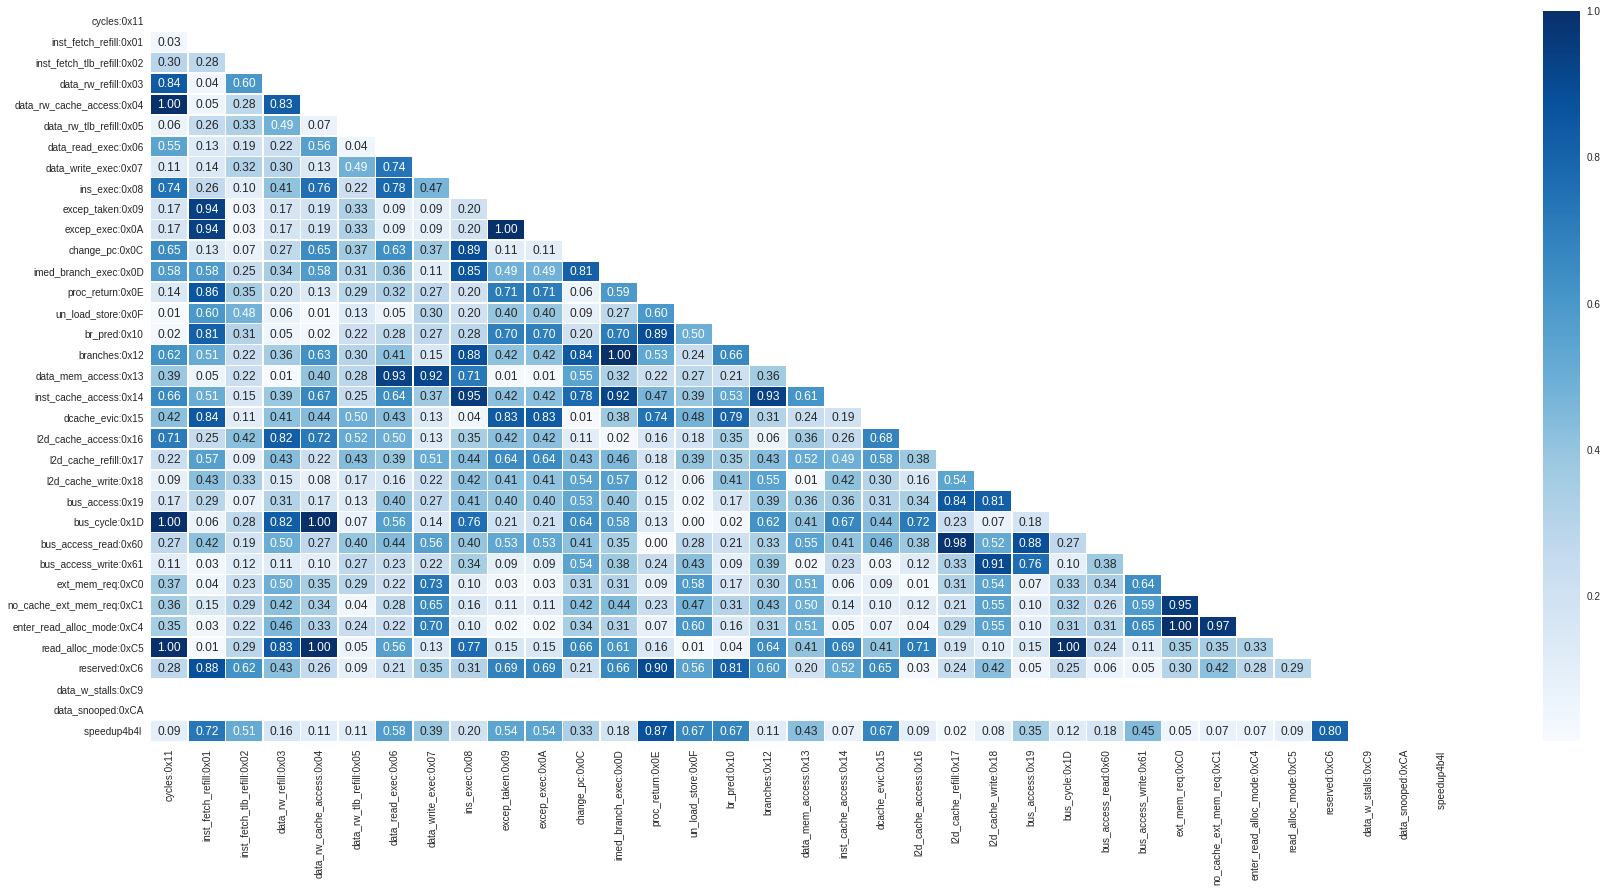

In [14]:
dictionary = get_features("/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/performance/4l.csv","speedup4b",0.50)
plot_correlation_between_features_selected("/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/performance/4l.csv",list(dictionary.keys()),len(dictionary.keys()))


In [15]:
df = pd.read_csv("/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/NEW/power/4b4l_A7_power_multitarget.csv")
correlation_matriz = df.corr("pearson")
#correlation_matriz = df.corr("spearman")
print(abs(correlation_matriz['power4b']).sort_values(ascending=False))

power4b                       1.000000
power4b4l                     0.860205
bus_cycle:0x1D                0.648647
cycles:0x11                   0.633314
power4l                       0.607379
ext_mem_req:0xC0              0.576588
l2d_cache_access:0x16         0.576536
data_read_exec:0x06           0.575748
bus_access:0x19               0.565659
ins_exec:0x08                 0.556038
l2d_cache_refill:0x17         0.542321
data_rw_refill:0x03           0.538470
bus_access_read:0x60          0.537220
bus_access_write:0x61         0.532705
data_rw_cache_access:0x04     0.528986
l2d_cache_write:0x18          0.525366
data_mem_access:0x13          0.521702
dcache_evic:0x15              0.516934
inst_cache_access:0x14        0.511215
reserved:0xC6                 0.419581
data_write_exec:0x07          0.382880
data_w_stalls:0xC9            0.369700
change_pc:0x0C                0.357657
imed_branch_exec:0x0D         0.338183
read_alloc_mode:0xC5          0.323204
branches:0x12            

# Hierarchical Cluster Analyses(HCA)

Basically, HCA groups similar objects into groups called clusters. The endpoint is a set of clusters, where each cluster is distinct from each other cluster, and the objects within each cluster are broadly similar to each other. This technique is important to eliminate redundancies in building our model.

In [16]:
def drop_constant_column(dataframe):
    """
    Drops constant value columns of pandas dataframe.
    """
    return dataframe.loc[:, (dataframe != dataframe.iloc[0]).any()]

#this function can just plot hca or return correlation of features per cluster 
def create_hca(path_file, index_config):
    df = pd.read_csv(path_file)

    if index_config == FOUR_LITTLE: 
       cluster_df = df.iloc[:,0:34]
       plt.figure(figsize=(15, 9))
    elif index_config == FOUR_BIG:
       cluster_df = df.iloc[:,0:57]
       plt.figure(figsize=(15, 12))
    elif index_config == FOUR_LITTLE_FOUR_BIG:
       cluster_df = df.iloc[:,0:90]
       plt.figure(figsize=(23, 18))
    else:
       print("Erro index config !!!")

    new_cluster_df = drop_constant_column(cluster_df)
    corr = 1 - new_cluster_df.corr().abs()  
    corr_condensed = shc.distance.squareform(corr) # convert to condensed

    z = shc.linkage(corr_condensed, method='average')
    dendrogram = shc.dendrogram(z,orientation="right",labels=corr.columns,leaf_rotation=0,leaf_font_size=10) #if orientation right, change rotation to 0

    plt.show()

def get_features_per_cluster(path_file, index_config, number_of_clusters, type_of_model, type_of_target):

    df = pd.read_csv(path_file)
    
    if index_config == FOUR_LITTLE: 
       cluster_df = df.iloc[:,0:34]
       plt.figure(figsize=(15, 9))
    elif index_config == FOUR_BIG:
       cluster_df = df.iloc[:,0:57]
       plt.figure(figsize=(15, 12))
    elif index_config == FOUR_LITTLE_FOUR_BIG:
       cluster_df = df.iloc[:,0:90]
       plt.figure(figsize=(23, 18))
    else:
       print("Erro index config !!!")

    new_cluster_df = drop_constant_column(cluster_df)
    corr = 1 - new_cluster_df.corr().abs()  
    corr_condensed = shc.distance.squareform(corr) # convert to condensed

    z = shc.linkage(corr_condensed, method='average')

    tree = shc.cut_tree(z, n_clusters = number_of_clusters)

    feat_per_cluster = [[] for i in range(0, number_of_clusters)]#create list of features for each cluster
    feat_correlation = [[] for i in range(0, number_of_clusters)]

    for i in range(len(new_cluster_df.columns)):    
       cluster_id = tree[i][0]       
       feat_per_cluster[cluster_id].append(df.columns[i])#add elements to its clusters

        
    if type_of_model == FILTER_METHOD:
       if type_of_target == POWER_TARGET:
          target = "power"
       elif index_config == 0:
          target = "speedup4b"
       elif index_config == 1:
          target = "speedup4l"
       elif index_config == 2:
          target = "speedup4b"       
       dictionary = get_features_filter(path_file,target,0.0)
    #PRECISO AJUSTAR DE MODO QUE TODOS CONSIGAM RETORNAR UM DICIONÁRIO ...PRECISO VER ISSO
    elif type_of_model == FEATURE_IMPORTANCE_DTR or type_of_model == FEATURE_IMPORTANCE_RFR :
       dictionary = select_feature_importance(path_file, type_of_model,type_of_target)
    else:
       print("Erro type of model!! ",type_of_model)
       dictionary = {}

          
        
    #just check if dictionary is correct!    
    if index_config == FOUR_LITTLE:
        if (len(dictionary) != 34):
            print("Error! Dictionary 4l should have 33 but has only:",len(dictionary))
    elif index_config == FOUR_BIG:
        if (len(dictionary) != 57):
            print("Error! Dictionary 4b should have 56 but has only:",len(dictionary))
    elif index_config == FOUR_LITTLE_FOUR_BIG:
            if (len(dictionary) != 90):
                print("Error! Dictionary should have 89 but has only:",len(dictionary))
    
    for i in range(number_of_clusters):
      for j in range(len(feat_per_cluster[i])):     
         feat_correlation[i].append(dictionary.get(feat_per_cluster[i][j]))  

    #This part correct this problem: TypeError: '>' not supported between instances of 'float' and 'NoneType'
    for i in range(number_of_clusters):
       for j in range(len(feat_per_cluster[i])-1):
           if feat_correlation[i][j] == None:               
              feat_correlation[i].pop(j)
              feat_per_cluster[i].pop(j)

    #features_correlation_per_cluster = [[] for i in range(0, number_of_clusters)] 
    for i in range(number_of_clusters):
      result = dict(zip(feat_per_cluster[i],feat_correlation[i]))
      print(sorted(result.items(), key=operator.itemgetter(1),reverse=True))
      #features_correlation_per_cluster[i].append(sorted(result.items(), key=operator.itemgetter(1),reverse=True))

    #return features_correlation_per_cluster  



## HCA - 4l dataset

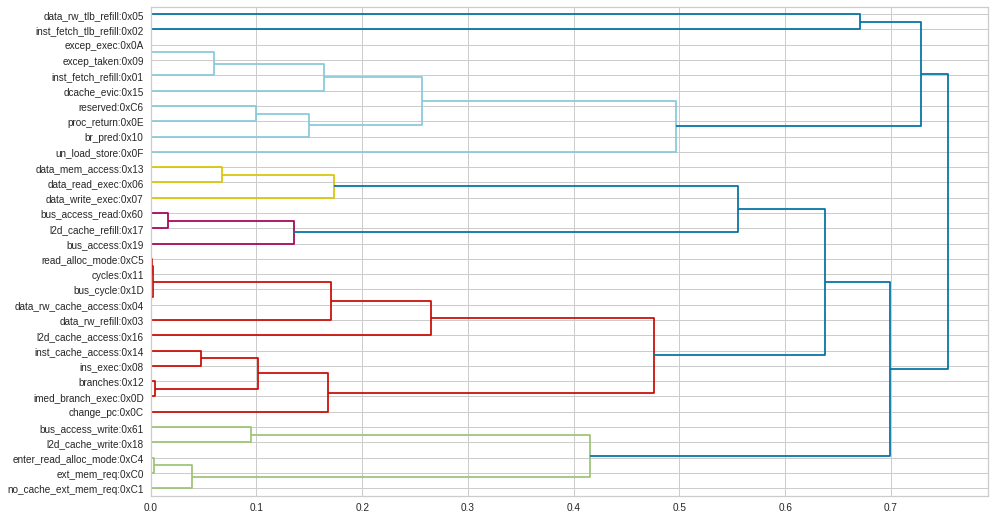

In [18]:
create_hca("/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/performance/4l.csv", FOUR_LITTLE)

# Wrapper Method

Wrapper-based methods use models to decide which pmcs to select.

In [22]:
#here cycles is selected in the begin
def select_feature_RFI(file_path, config, type_of_model,type_of_target):    
    index_pmcs_selected = []
    target_columns = 3
    best_score = -1
    best_index = -1
    cycle_index = 0
    start_index = 0

    df = pd.read_csv(file_path)
    for i in df.columns:
       new_df=remove_outlier(df, i)
           
    end_index = len(df.columns)-target_columns         

    if type_of_target == POWER_TARGET:
       array = new_df.values       
    elif type_of_target == PERFORMANCE_TARGET:  #Performance we dont call remove_outliers 
       array = df.values
       if config==FOUR_LITTLE_FOUR_BIG_L:
           end_index=34
       elif config==FOUR_LITTLE_FOUR_BIG_B:
           start_index=34
           cycle_index=34
       
    if config==FOUR_LITTLE:
        total_pmcs = 4
    elif config==FOUR_BIG:  
        total_pmcs = 6
    elif config==FOUR_LITTLE_FOUR_BIG_L:
        total_pmcs = 4
        end_index = 34
    elif config==FOUR_LITTLE_FOUR_BIG_B:
        total_pmcs = 6        
    else:
        print("Error config!!")
 
    pmcs_selected = array[:,[cycle_index]] 
    index_pmcs_selected.append(cycle_index)
    for j in range(total_pmcs):       
        for i in range (start_index,end_index): 
            if type_of_model == RFI_LINEAR:
                if type_of_target == PERFORMANCE_TARGET:
                    print("O modelo linear não suporta multitarget!!!")
                else:
                    model = LinearRegression()
            elif type_of_model == RFI_DTR:
                model = DecisionTreeRegressor()             
            elif type_of_model == RFI_RFR:
                model = RandomForestRegressor(n_estimators=50, max_depth=30)
            

            if i not in index_pmcs_selected:                
                column = array[:,[i]] #seleciona a coluna a ser testada    
                X = np.concatenate((pmcs_selected, column), axis=1) #concatena com os atuais pmus
                Y = array[:, (len(df.columns) - target_columns): len(df.columns)]
                
                #dataset performance is too small, so i need to use all datast
                if type_of_target == PERFORMANCE_TARGET:
                   model.fit(X, Y)                   
                   y_pred = model.predict(X)
                   current_score = r2_score(Y,y_pred)           
                #dataset power is good, so i can use kfold   
                elif type_of_target == POWER_TARGET: 
                   cv = KFold(n_splits=5, shuffle=True)                   
                   scores = cross_val_score(model, X, Y, cv = cv, scoring='r2')                
                   current_score = scores.mean()                                   

                if current_score > best_score:
                    best_score = current_score
                    best_index = i
        if best_index not in index_pmcs_selected:      
            #print("PMU selected:",df.columns.values[best_index]," Score:",best_score)
            index_pmcs_selected.append(best_index)
            column = array[:,[best_index]] 
            pmcs_selected = np.concatenate((pmcs_selected, column), axis=1) 


    string_pmcs_selected = []
    for s in range(len(index_pmcs_selected)):
        string_pmcs_selected.append(df.columns[index_pmcs_selected[s]])
       
    X = array[:,index_pmcs_selected]
    Y = array[:, (len(df.columns) - target_columns): len(df.columns)]

   
    if type_of_target == PERFORMANCE_TARGET:        
        model.fit(X, Y)
        y_pred = model.predict(X)
        score = r2_score(Y,y_pred)
        #score = model.score(X,Y)   
        return score, index_pmcs_selected,string_pmcs_selected
    elif type_of_target == POWER_TARGET:   
        #cv = ShuffleSplit(n_splits=10)
        cv = KFold(n_splits=5, shuffle=True)
        scores = cross_val_score(model, X, Y, cv = cv, scoring='r2')
        #visualizer = CVScores(model, cv=cv, scoring='r2')
        #visualizer.fit(X, Y)        # Fit the data to the visualizer
        return scores.mean(),index_pmcs_selected,string_pmcs_selected

In [25]:
dataset = [("\nResult of 4l - Test==Train","/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/NEW/performance/4l_performance_multitarget.csv",FOUR_LITTLE, 5, RFI_RFR, PERFORMANCE_TARGET),
           ("\nResult of 4b - Test==Train","/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/NEW/performance/4b_performance_multitarget.csv",FOUR_BIG, 7, RFI_RFR, PERFORMANCE_TARGET),
           ("\nResult of 4b4l_A7 - Test==Train","/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/NEW/performance/4b4l_performance_multitarget.csv",FOUR_LITTLE_FOUR_BIG_L, 5, RFI_RFR, PERFORMANCE_TARGET),
           ("\nResult of 4b4l_A15 - Test==Train","/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/NEW/performance/4b4l_performance_multitarget.csv",FOUR_LITTLE_FOUR_BIG_B, 7, RFI_RFR, PERFORMANCE_TARGET)
          ]

for out_string,file_name, config, num_pmcs, selection_feature_type, target_type in dataset:
    list_scores = []
    list_index_pmcs = []
    my_dict = {}
    start = timeit.default_timer()
    for i in range(g_number_iterations):
        #print(end = '.')
        score,index_pmcs_selected,string_pmcs_selected  = select_feature_RFI(file_name,config, selection_feature_type,target_type)
        list_scores.append(score)
        list_index_pmcs.append(index_pmcs_selected)

        for j in range(len(index_pmcs_selected)):
            #my_dict[str(string_pmcs_selected[j])] += 1
            if my_dict.__contains__(string_pmcs_selected[j]):
                my_dict[string_pmcs_selected[j]] += 1
            else:
                my_dict[string_pmcs_selected[j]] = 1

    print(out_string)
    print_performance(list_scores,list_index_pmcs)
    print_selected_pmcs(my_dict, num_pmcs)
    print("\nTime(minutes) {0:.2f} ".format(round((timeit.default_timer() - start))/60,2))


Result of 4l - Test==Train

Mean Accuracy: 0.97  ['00', '13', '21']
Mean Accuracy: 0.93  ['00', '02', '19']
Mean Accuracy: 0.95  ['00', '13', '01', '15', '33']
Mean Accuracy: 0.94  ['00', '13', '22', '02']
Mean Accuracy: 0.96  ['00', '02', '04']
Mean Accuracy: 0.93  ['00', '01', '26', '28']
Mean Accuracy: 0.95  ['00', '13', '27', '20']
Mean Accuracy: 0.93  ['00', '01', '15']
Mean Accuracy: 0.98  ['00', '33', '06']
Mean Accuracy: 0.94  ['00', '02', '17']
Mean Accuracy: 0.90  ['00', '13', '16']
Mean Accuracy: 0.96  ['00', '13', '23']
Mean Accuracy: 0.96  ['00', '13', '26']
Mean Accuracy: 0.98  ['00', '01', '30']
Mean Accuracy: 0.97  ['00', '13', '03']
Mean Accuracy: 0.95  ['00', '01', '15', '04']
Mean Accuracy: 0.96  ['00', '13', '03']
Mean Accuracy: 0.94  ['00', '01', '18']
Mean Accuracy: 0.93  ['00', '02', '06', '24', '30']
Mean Accuracy: 0.95  ['00', '13', '29', '01']
Mean Accuracy: 0.95  ['00', '01', '24']
Mean Accuracy: 0.93  ['00', '01', '27']
Mean Accuracy: 0.97  ['00', '13', '24

# Test Predictor


In [28]:
print("4l")
print("Performance")
for i in range(5):
    df = pd.read_csv("/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/NEW/performance/4l_performance_multitarget.csv")     
    X = df[['cycles:0x11','proc_return:0x0E','inst_fetch_refill:0x01','dcache_evic:0x15','un_load_store:0x0F']].values
    Y = df[['speedup4l','speedup4b','speedup4b4l ']].values

    model = RandomForestRegressor(n_estimators=50, max_depth=30)
    model.fit(X, Y)
    y_pred = model.predict(X)
    #print(r2_score(Y,y_pred))
    score_regression(Y,y_pred)

print("Power")    
for i in range(5):
    new_df = pd.read_csv("/mntDrive/My Drive/UFBA - DOUTORADO/0_Heterogeneous_Processor/Feature Selection/data/NEW/power/4l_power_multitarget.csv")
    for i in new_df.columns:
       df=remove_outlier(new_df, i)
    X = df[['cycles:0x11','proc_return:0x0E','inst_fetch_refill:0x01','dcache_evic:0x15','un_load_store:0x0F']].values
    Y = df[['power4l','power4b','power4b4l']].values
    
    model = RandomForestRegressor(n_estimators=50, max_depth=30)
    model.fit(X, Y)
    y_pred = model.predict(X)
    #print(r2_score(Y,y_pred))
    score_regression(Y,y_pred)

4l
Performance
---Regression Score--- 
R2 = 0.927491040581906
RMSE = 0.27525302143185937
RMSLE (kaggle) = 0.08191581192311313
MAE = 0.13316955583333348

---Regression Score--- 
R2 = 0.9643144939421
RMSE = 0.1893976187590301
RMSLE (kaggle) = 0.07423679921294844
MAE = 0.12524350583333335

---Regression Score--- 
R2 = 0.9468195320060154
RMSE = 0.23213933139453874
RMSLE (kaggle) = 0.07803177604278168
MAE = 0.12896465249999997

---Regression Score--- 
R2 = 0.9588847855723355
RMSE = 0.19863586120578644
RMSLE (kaggle) = 0.0589846745564873
MAE = 0.11881009083333338

---Regression Score--- 
R2 = 0.9257697885634667
RMSE = 0.2739462510116095
RMSLE (kaggle) = 0.07427101026365758
MAE = 0.13497546083333345

Power
---Regression Score--- 
R2 = 0.9189056338179197
RMSE = 0.9590278182421175
RMSLE (kaggle) = 0.11259006154691374
MAE = 0.5138631245791244

---Regression Score--- 
R2 = 0.9340141698374049
RMSE = 0.8663953056908015
RMSLE (kaggle) = 0.10238366237875275
MAE = 0.49004015488215485

---Regression Sc

# Plots

## Plot switch config - Performance


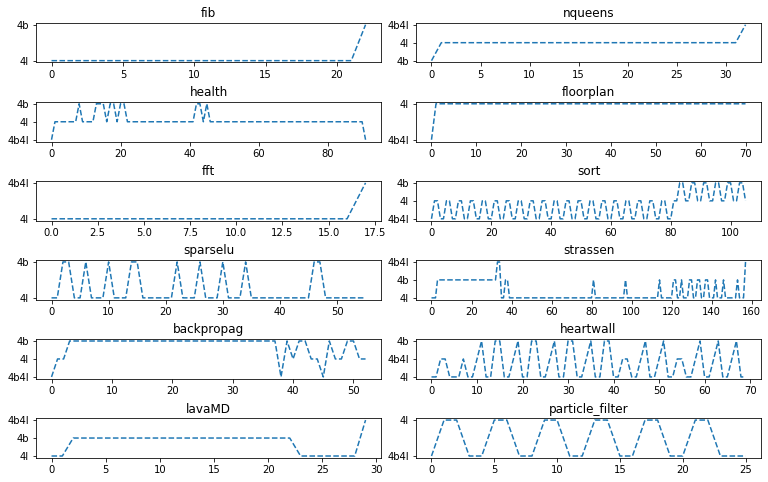

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_apps = 12

configs = [["4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b"],
["4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b4l"],
["4b4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4b","4b","4b","4l","4b","4b","4l","4b","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4b","4l","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b4l"],
["4b4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l"],
["4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b4l"],
["4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b","4b","4l","4l","4b","4b","4l","4l","4b","4b","4l","4l","4b","4b","4l","4l","4b","4b","4l","4l","4b","4b","4l"],
["4l","4l","4b","4b","4l","4l","4b","4l","4l","4l","4b","4l","4l","4l","4b","4b","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4b","4l","4l","4l","4b","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4b","4l","4l","4l","4l","4l","4l","4l","4l"],
["4l","4l","4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b4l","4b4l","4l","4l","4b","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4b","4b","4l","4l","4b","4l","4l","4l","4b","4b","4l","4l","4b","4b","4l","4l","4b","4b","4l","4l","4l","4b","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4b4l"],
["4b4l","4l","4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b4l","4b","4l","4b","4b","4l","4l","4b4l","4b","4l","4l","4b","4b","4l","4l"],
["4l","4l","4b4l","4b4l","4l","4l","4l","4b4l","4l","4l","4b4l","4b","4l","4l","4b","4b","4l","4l","4b4l","4b","4l","4l","4b","4b","4l","4l","4b4l","4b","4l","4l","4b","4b","4l","4l","4b4l","4b","4l","4l","4b","4b","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b","4l","4l","4b4l","4b","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b","4l","4l","4b4l","4b","4l","4l","4b4l","4b","4l","4l"],
["4l","4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4l","4l","4l","4l","4l","4l","4b4l"],
["4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4b4l"]]
apps = ["fib", "nqueens", "health","floorplan","fft","sort","sparselu","strassen","backpropag", "heartwall","lavaMD","particle_filter"]

y_ticks_label = ['4l', '4b', '4b4l']

fig, axs = plt.subplots(6,2,figsize=(13, 8))
#fig.suptitle('Sharing both axes')
#fig.set_figheight(25)
#fig.set_figwidth(15)

for i in range(6):
    for j in range(2):       
       axs[i,j].plot(configs[(2*i) + j],linestyle='--')
       #axs[i].set_yticklabels(y_ticks_label)
       #axs[i].yticks(configs[i],apps)
       axs[i,j].title.set_text(apps[(2*i) + j])
    
plt.subplots_adjust(hspace=1.0,wspace = 0.1 )
plt.show()

## Plot switch config


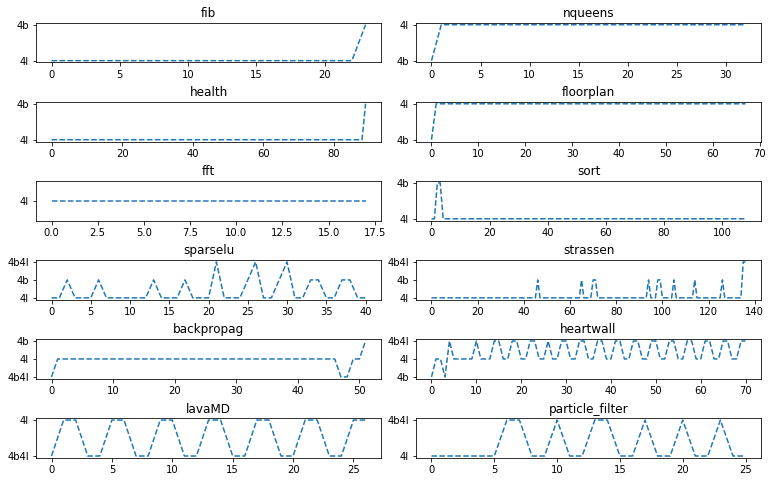

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_apps = 12

configs = [["4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b"],
["4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l"],
["4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b"],
["4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l"],
["4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l"],
["4l","4l","4b","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l"],
["4l","4l","4b","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4b","4l","4l","4l","4b4l","4l","4l","4l","4b","4b4l","4l","4l","4b","4b4l","4l","4l","4b","4b","4l","4l","4b","4b","4l","4l"],
["4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4b","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4b","4b","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l","4l","4l","4l","4l","4l","4l","4l","4b4l","4b4l"],
["4b4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b4l","4b4l","4l","4l","4b"],
["4b","4l","4l","4b","4b4l","4l","4l","4l","4l","4l","4b4l","4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l"],
["4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4b4l","4l","4l"],
["4l","4l","4l","4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4l","4l","4b4l","4b4l","4l","4l","4b4l","4l","4l","4b4l","4l","4l","4b4l","4l","4l"]
    ]
apps = ["fib", "nqueens", "health","floorplan","fft","sort","sparselu","strassen","backpropag", "heartwall","lavaMD","particle_filter"]

y_ticks_label = ['4l', '4b', '4b4l']

fig, axs = plt.subplots(6,2,figsize=(13, 8))
#fig.suptitle('Sharing both axes')
#fig.set_figheight(25)
#fig.set_figwidth(15)

for i in range(6):
    for j in range(2):       
       axs[i,j].plot(configs[(2*i) + j],linestyle='--')
       #axs[i].set_yticklabels(y_ticks_label)
       #axs[i].yticks(configs[i],apps)
       axs[i,j].title.set_text(apps[(2*i) + j])
    
plt.subplots_adjust(hspace=1.0,wspace = 0.1 )
plt.show()

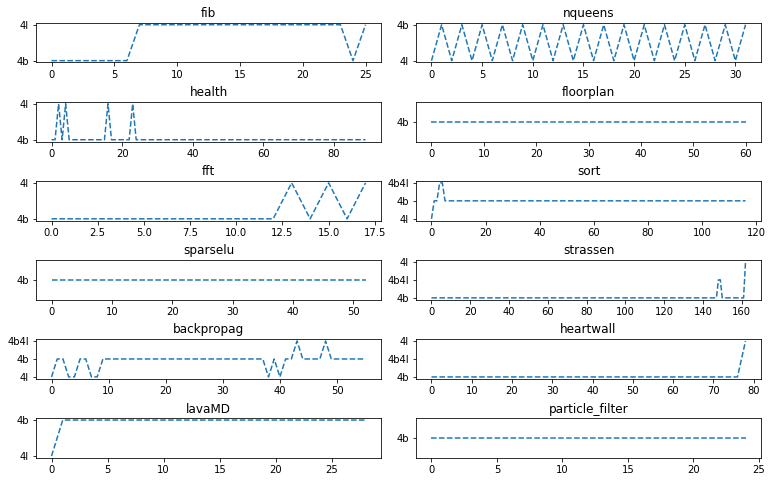

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_apps = 12

configs = [["4b","4b","4b","4b","4b","4b","4b","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4l","4b","4l"],
["4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b","4l","4b"],
["4b","4b","4l","4b","4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4l","4b","4b","4b","4b","4b","4b","4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b"],
["4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b"],
["4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4l","4b","4l","4b","4l"],
["4l","4b","4b","4b4l","4b4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b"],
["4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b"],
["4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b4l","4b4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4l"],
["4l","4b","4b","4l","4l","4b","4b","4l","4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4l","4b","4l","4b","4b","4b4l","4b","4b","4b","4b","4b4l","4b","4b","4b","4b","4b","4b","4b"],
["4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b4l","4l"],
["4l","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b"],
["4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b","4b"]]

apps = ["fib", "nqueens", "health","floorplan","fft","sort","sparselu","strassen","backpropag", "heartwall","lavaMD","particle_filter"]

y_ticks_label = ['4l', '4b', '4b4l']

fig, axs = plt.subplots(6,2,figsize=(13, 8))
#fig.suptitle('Sharing both axes')
#fig.set_figheight(25)
#fig.set_figwidth(15)

for i in range(6):
    for j in range(2):       
       axs[i,j].plot(configs[(2*i) + j],linestyle='--')
       #axs[i].set_yticklabels(y_ticks_label)
       #axs[i].yticks(configs[i],apps)
       axs[i,j].title.set_text(apps[(2*i) + j])
    
plt.subplots_adjust(hspace=1.0,wspace = 0.1 )
plt.show()

## Execution time 


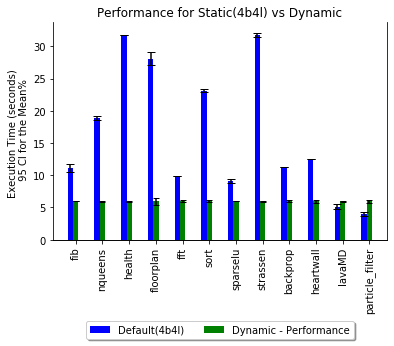

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

apps = ['fib','nqueens','health','floorplan','fft','sort','sparselu','strassen','backprop','heartwall','lavaMD','particle_filter']
optimization=['Performance','EDP']


#default
default_exec_time = [11.07,18.93,31.70,28.06,9.82,23.14,9.04,31.77,11.30,12.53,5.13,3.97]                     
default_exec_time_error = [0.61,0.29,0.00,0.98,0.00,0.20,0.30,0.35,0.00,0.00,0.33,0.30]

#default_power = [87.72,149.66,324.06,326.57,94.61,170.72,130.75,326.74,62.06,173.37,74.08,33.96]
#default_power_error = [12.54,5.25,4.68,14.44,2.10,3.52,4.65,8.93,0.86,5.84,4.65,1.75]


#dynamic
dynamic_exec_time = [ 5.98,7.13,20.58,13.74,3.77,25.85,11.89,37.25,11.62,17.64,6.27,5.07]

#dynamic_power = [ [52.48,63.72,229.45,180.67,30.93,204.03,135.77,351.67,81.22,214.09,74.50,54.99], 
#                  [36.80,45.87,232.99,170.39,34.38,201.35,131.90,329.64,79.90,216.73,75.42,53.19],
#                  [38.47,73.98,234.70,177.19,36.01,205.51,138.15,334.46,81.31,207.11,78.75,61.30], 
#                  [36.13,52.05,233.11,183.25,34.83,210.24,145.85,325.12,81.40,210.65,75.22,58.58]
 #                ]

dynamic_exec_time_error = [ [0.05,0.07,0.07,0.56,0.11,0.15,0.03,0.09,0.21,0.22,0.07,0.22], 
                            [0.07,0.07,0.08,0.22,0.11,0.14,0.06,0.16,0.14,0.11,0.09,0.07],
                            [0.07,0.04,0.07,0.57,0.09,0.13,0.10,0.18,0.14,0.40,0.09,0.06], 
                            [0.07,0.04,0.09,0.48,0.07,0.11,0.06,0.09,0.17,0.35,0.04,0.11]
                          ]
#dynamic_power_error = [ [6.20,10.38,12.11,15.83,6.20,13.46,9.17,13.49,8.06,14.51,7.78,4.79],                          
#                        [7.99,9.52,4.33,10.11,4.91,8.02,7.86,10.50,5.22,17.21,7.38,7.16],
#                        [4.94,6.25,7.15,15.44,5.23,6.07,11.62,9.47,5.80,17.80,7.17,5.39],                          
#                        [6.50,11.64,6.67,14.69,2.10,7.66,10.91,6.17,5.99,15.96,5.52,7.62] 
#                      ]

number_switch_list = [ [22.30,38.20,39.50,46.70,55.90,70.40,92.60,142.80,151.10,187.10,199.50,212.20],                                      
                       [15.70,26.60,27.60,61.70,69.70,84.60,103.20,130.10,135.50,170.50,183.10,194.50],
                       [16.50,27.10,28.10,28.90,34.80,88.10,104.70,128.70,130.70,162.90,175.80,182.00],                                      
                       [16.10,23.10,24.30,52.10,60.20,78.40,81.80,85.00,90.00,109.00,109.50,117.90]
                     ]


fig, ax = plt.subplots(1,1)

#PLOT DO GRÁFICO 2
title_name = "Execution Time for Static(4b4l) vs Dynamic"   
plt.title(title_name,fontsize=12)
x_pos = np.arange(len(apps))

ax.title.set_text('Performance for Static(4b4l) vs Dynamic')
ax.set_ylabel('Execution Time (seconds) \n 95 CI for the Mean%')
ax.bar(x_pos, default_exec_time, yerr=default_exec_time_error, width=0.2, color='b',capsize=4,label="Default(4b4l)")
ax.bar(x_pos+0.2, dynamic_exec_time[0], yerr=dynamic_exec_time_error[0], width=0.2, color='g',tick_label=apps,capsize=3, label="Dynamic - Performance")
ax.spines['top'].set_position('zero') #remove top lines
#ax[0].legend(bbox_to_anchor=(0.5, 0.95))#legend position 
ax.legend()#legend position 


plt.sca(ax)
plt.xticks(rotation=90)

#plt.legend()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), shadow=True, ncol=2)
#plt.gcf().subplots_adjust(bottom=0.25)#position image inside plot
#plt.subplots_adjust(hspace=0.1)#distance between subplot
#file_name= method + ".png"
#plt.savefig(file_name)
plt.show()
#plt.clf() # clear the current figure
#plt.cla() # clear the current axes


## Power


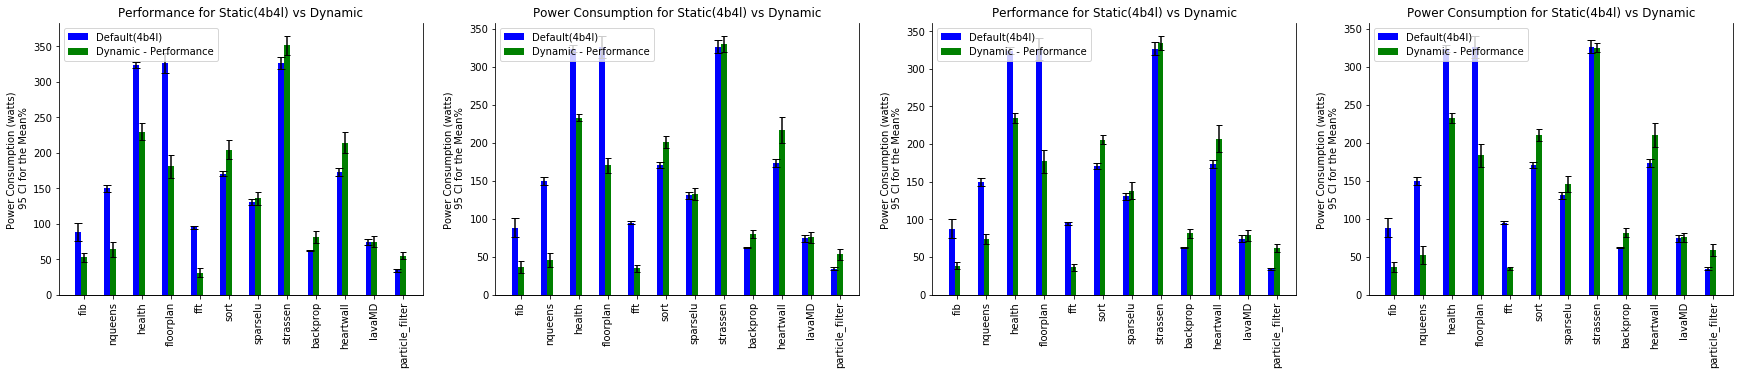

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

apps = ['fib','nqueens','health','floorplan','fft','sort','sparselu','strassen','backprop','heartwall','lavaMD','particle_filter']
optimization=['Performance','EDP']


#default
default_exec_time = [13.10,13.00,27.00,27.40,9.00,23.10,8.70,29.10,11.00,14.00,7.50,6.30]                     
default_exec_time_error = [0.61,0.29,0.00,0.98,0.00,0.20,0.30,0.35,0.00,0.00,0.33,0.30]

default_power = [87.72,149.66,324.06,326.57,94.61,170.72,130.75,326.74,62.06,173.37,74.08,33.96]
default_power_error = [12.54,5.25,4.68,14.44,2.10,3.52,4.65,8.93,0.86,5.84,4.65,1.75]


#dynamic
dynamic_exec_time = [ [5.92,7.13,20.60,14.74,3.84,24.66,10.15,32.44,11.64,16.92,6.08,5.58], #approach 1                     
                      [5.71,7.07,20.70,15.57,3.87,24.69,10.06,30.70,11.48,16.86,6.14,5.24], #approach 2
                      [5.73,7.12,20.67,13.97,3.87,24.86,9.79,30.49,11.58,16.11,6.16,5.91], #approach 3                     
                      [5.75,6.94,20.69,15.33,3.81,25.15,11.23,30.00,11.48,16.96,6.21,5.80] #approach 4
                    ]

dynamic_power = [ [52.48,63.72,229.45,180.67,30.93,204.03,135.77,351.67,81.22,214.09,74.50,54.99], 
                  [36.80,45.87,232.99,170.39,34.38,201.35,131.90,329.64,79.90,216.73,75.42,53.19],
                  [38.47,73.98,234.70,177.19,36.01,205.51,138.15,334.46,81.31,207.11,78.75,61.30], 
                  [36.13,52.05,233.11,183.25,34.83,210.24,145.85,325.12,81.40,210.65,75.22,58.58]
                 ]

dynamic_exec_time_error = [ [0.05,0.07,0.07,0.56,0.11,0.15,0.03,0.09,0.21,0.22,0.07,0.22], 
                            [0.07,0.07,0.08,0.22,0.11,0.14,0.06,0.16,0.14,0.11,0.09,0.07],
                            [0.07,0.04,0.07,0.57,0.09,0.13,0.10,0.18,0.14,0.40,0.09,0.06], 
                            [0.07,0.04,0.09,0.48,0.07,0.11,0.06,0.09,0.17,0.35,0.04,0.11]
                          ]
dynamic_power_error = [ [6.20,10.38,12.11,15.83,6.20,13.46,9.17,13.49,8.06,14.51,7.78,4.79],                          
                        [7.99,9.52,4.33,10.11,4.91,8.02,7.86,10.50,5.22,17.21,7.38,7.16],
                        [4.94,6.25,7.15,15.44,5.23,6.07,11.62,9.47,5.80,17.80,7.17,5.39],                          
                        [6.50,11.64,6.67,14.69,2.10,7.66,10.91,6.17,5.99,15.96,5.52,7.62] 
                      ]

number_switch_list = [ [22.30,38.20,39.50,46.70,55.90,70.40,92.60,142.80,151.10,187.10,199.50,212.20],                                      
                       [15.70,26.60,27.60,61.70,69.70,84.60,103.20,130.10,135.50,170.50,183.10,194.50],
                       [16.50,27.10,28.10,28.90,34.80,88.10,104.70,128.70,130.70,162.90,175.80,182.00],                                      
                       [16.10,23.10,24.30,52.10,60.20,78.40,81.80,85.00,90.00,109.00,109.50,117.90]
                     ]


fig, ax = plt.subplots(1,4,figsize=(30,5))

#PLOT DO GRÁFICO 2
title_name = "Power Consumption (watts) for Static(4b4l) vs Dynamic"   
plt.title(title_name,fontsize=12)
x_pos = np.arange(len(apps))

ax[0].title.set_text('Performance for Static(4b4l) vs Dynamic')
ax[0].set_ylabel('Power Consumption (watts) \n 95 CI for the Mean%')
ax[0].bar(x_pos, default_power, yerr=default_power_error, width=0.2, color='b',capsize=4,label="Default(4b4l)")
ax[0].bar(x_pos+0.2, dynamic_power[0], yerr=dynamic_power_error[0], width=0.2, color='g',tick_label=apps,capsize=3, label="Dynamic - Performance")
ax[0].spines['top'].set_position('zero') #remove top lines
#ax[0].legend(bbox_to_anchor=(0.5, 0.95))#legend position 
ax[0].legend()#legend position 


ax[1].title.set_text('Power Consumption for Static(4b4l) vs Dynamic')
ax[1].set_ylabel('Power Consumption (watts) \n 95 CI for the Mean%')
ax[1].bar(x_pos, default_power, yerr=default_power_error, width=0.2, color='b',capsize=4,label="Default(4b4l)")
ax[1].bar(x_pos+0.2, dynamic_power[1], yerr=dynamic_power_error[1], width=0.2, color='g',tick_label=apps,capsize=3, label="Dynamic - Performance")
ax[1].spines['top'].set_position('zero') #remove top lines
ax[1].legend()#legend position 

ax[2].title.set_text('Performance for Static(4b4l) vs Dynamic')
ax[2].set_ylabel('Power Consumption (watts) \n 95 CI for the Mean%')
ax[2].bar(x_pos, default_power, yerr=default_power_error, width=0.2, color='b',capsize=4,label="Default(4b4l)")
ax[2].bar(x_pos+0.2, dynamic_power[2], yerr=dynamic_power_error[2], width=0.2, color='g',tick_label=apps,capsize=3, label="Dynamic - Performance")
ax[2].spines['top'].set_position('zero') #remove top lines
ax[2].legend()#legend position 

ax[3].title.set_text('Power Consumption for Static(4b4l) vs Dynamic')
ax[3].set_ylabel('Power Consumption (watts) \n 95 CI for the Mean%')
ax[3].bar(x_pos, default_power, yerr=default_power_error, width=0.2, color='b',capsize=4,label="Default(4b4l)")
ax[3].bar(x_pos+0.2, dynamic_power[3], yerr=dynamic_power_error[3], width=0.2, color='g',tick_label=apps,capsize=3, label="Dynamic - Performance")
ax[3].spines['top'].set_position('zero') #remove top lines
#ax[3].legend()#legend position 
ax[3].legend(loc='upper right')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)






plt.legend()
#plt.gcf().subplots_adjust(bottom=0.25)#position image inside plot
#plt.subplots_adjust(hspace=0.1)#distance between subplot
#file_name= method + ".png"
#plt.savefig(file_name)
plt.show()
#plt.clf() # clear the current figure
#plt.cla() # clear the current axes
